## 1. 네이버 기사 API 등록

    네이버 개발자 API 검색 -> 네이버 개발자 센터 NAVER Developers 네이버 오픈 API
    네이버 오픈 API : 네이버에서 쓰는 기능등을 사용할 수 있도록 제공해 준 것
    -> 보통 텍스트 마이닝시 사용하는 것은 '데이터 랩(검색어트랜드), 데이터랩(쇼핑인사이트), 검색'을  많이 사용

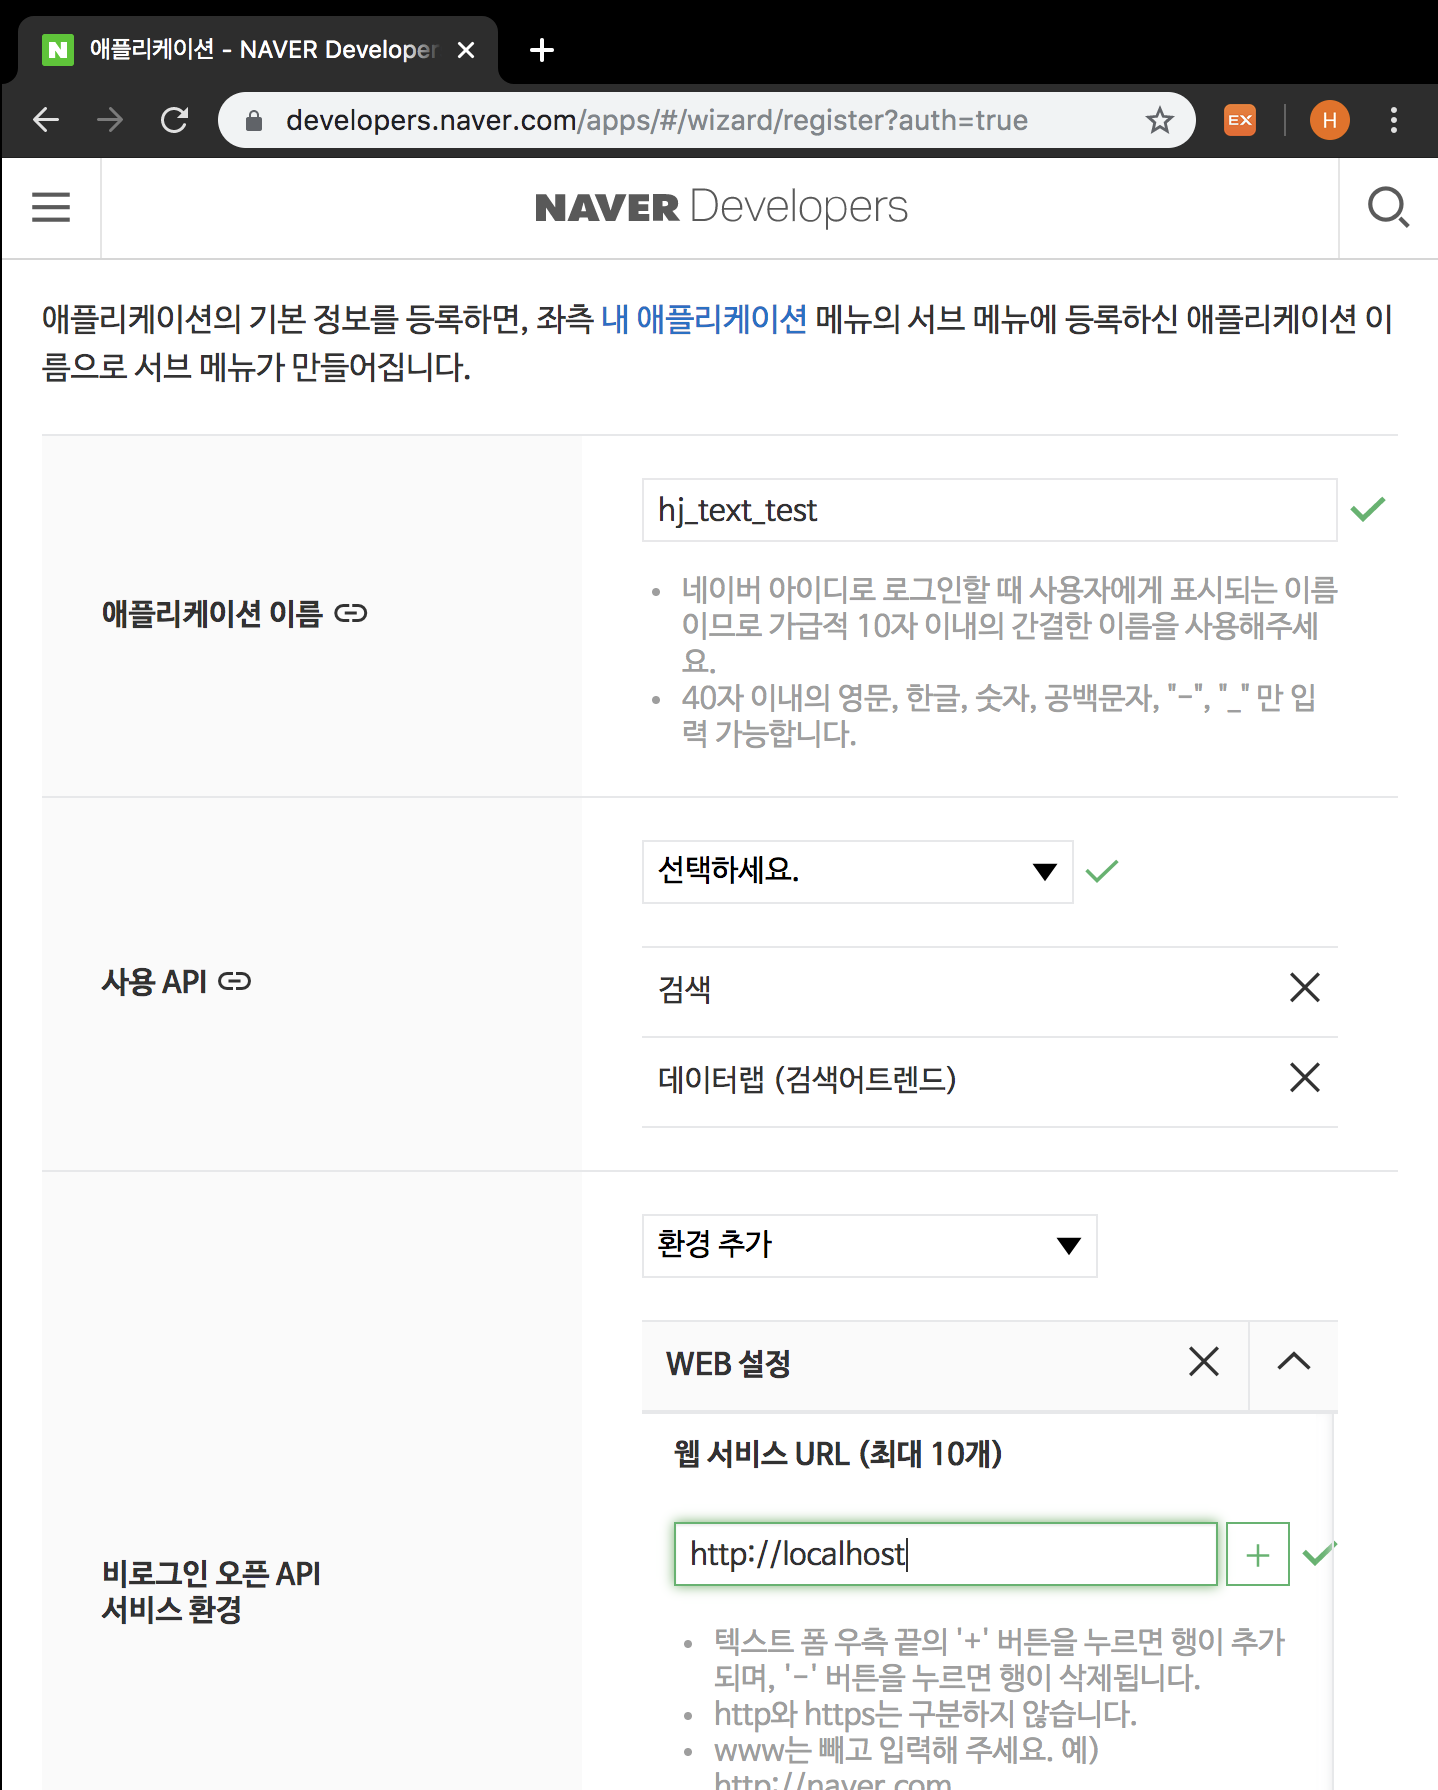

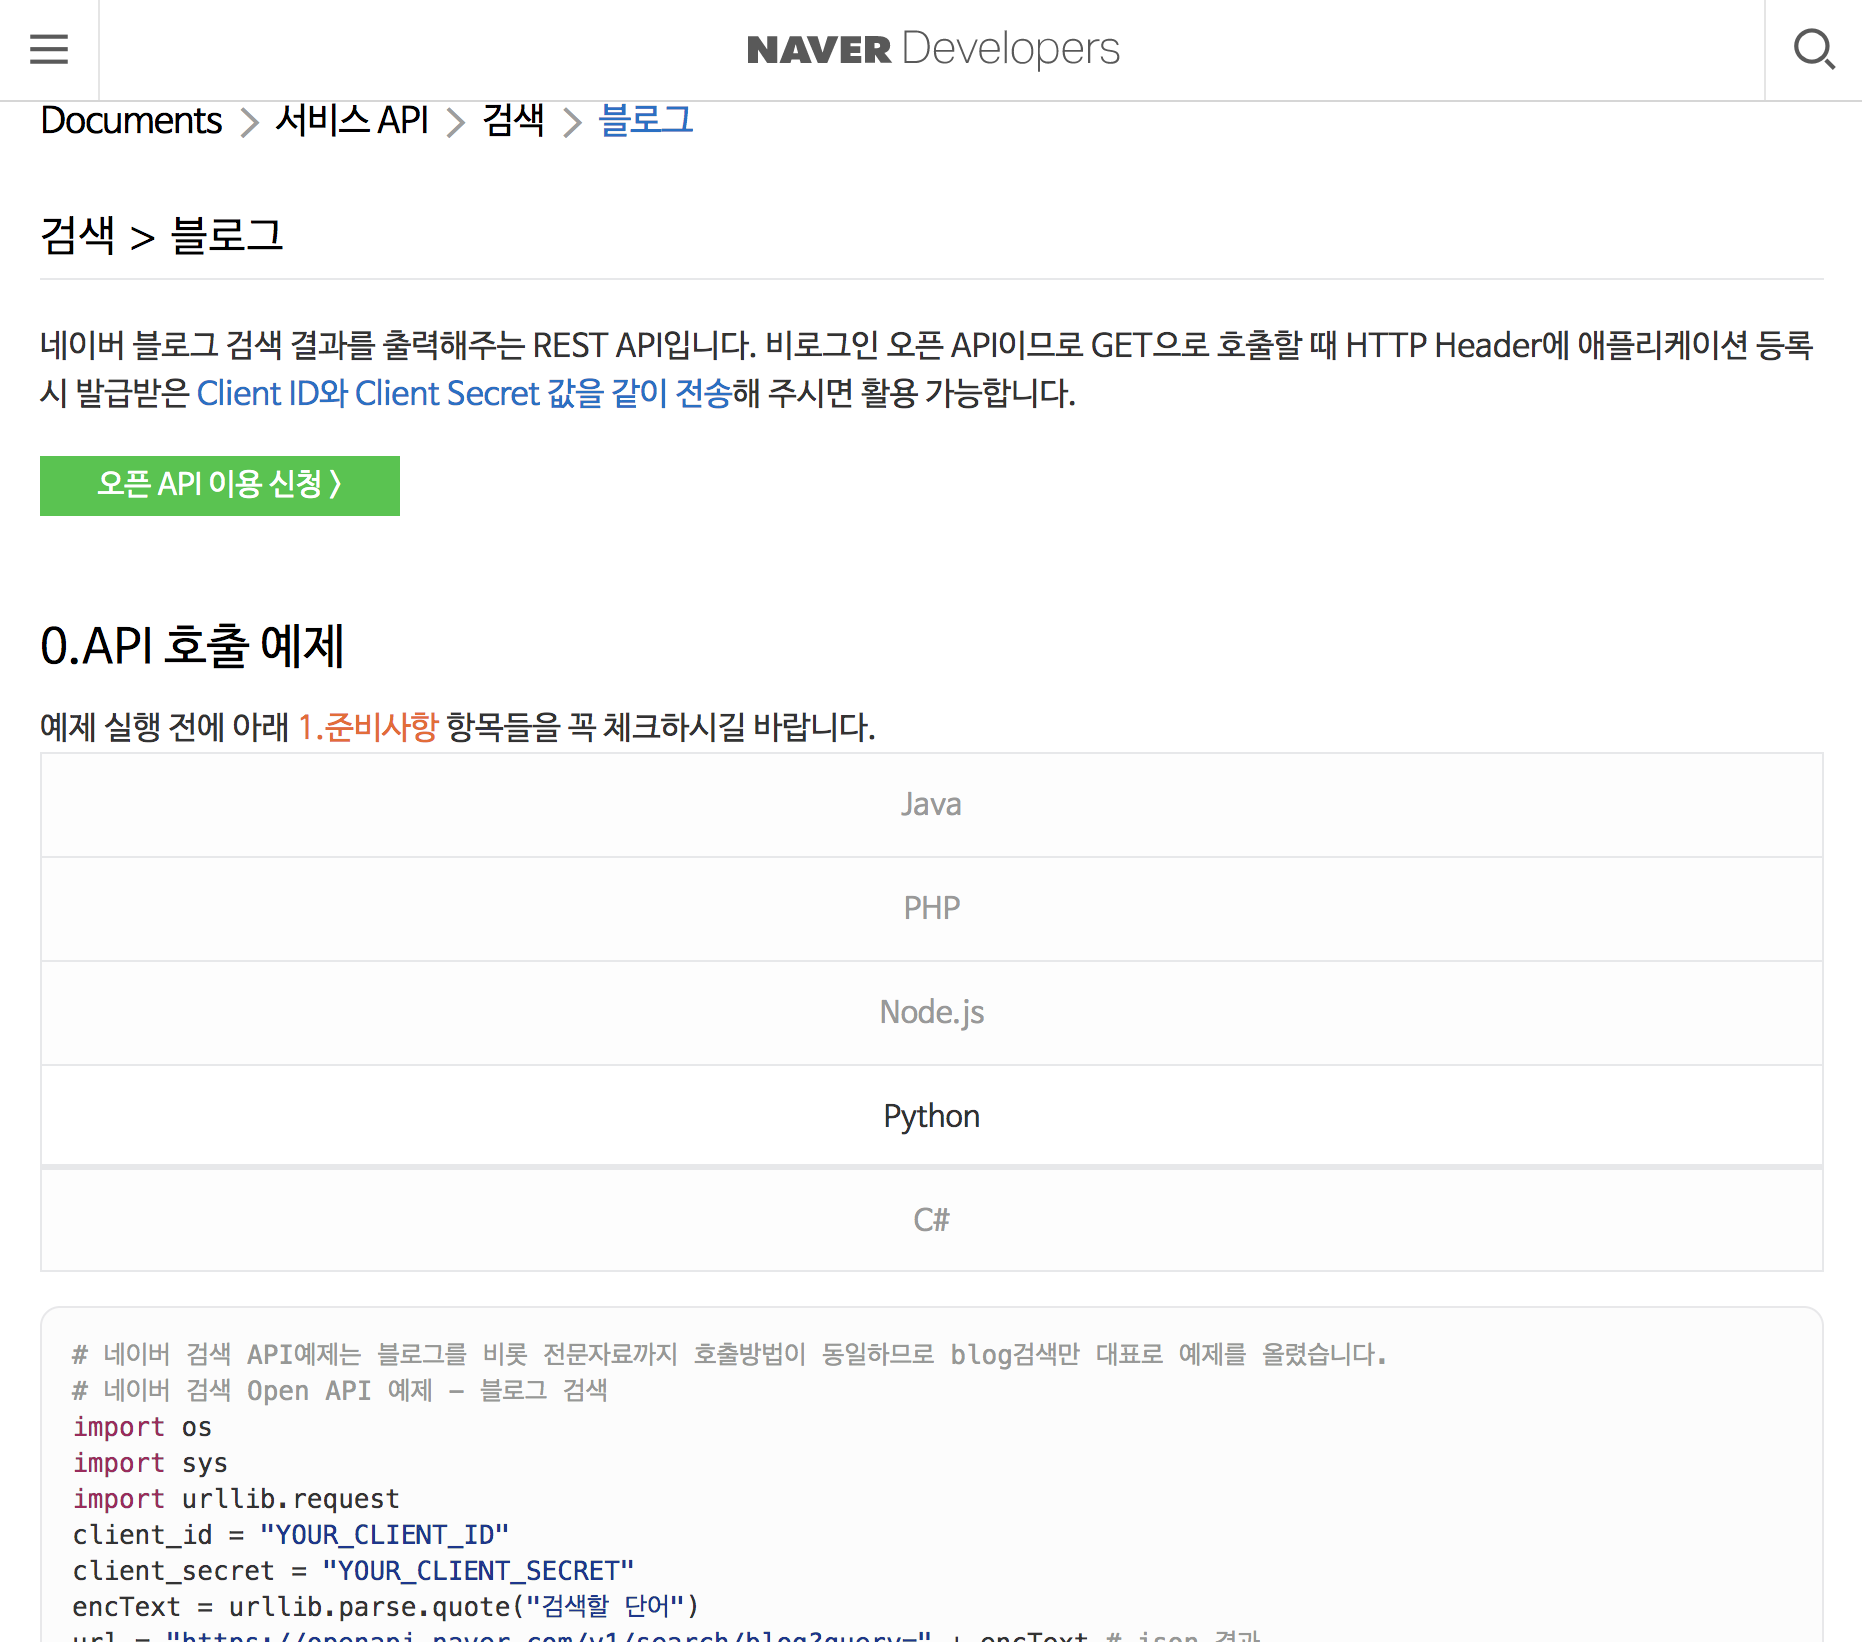

## 2. 네이버 뉴스 데이터 가져오기
1. 네이버 오픈 API로 기사 URL 크롤링
2. bs4 + selenium으로 기사 제목 및 내용 크롤링

In [1]:
# 네이버 검색 Open API 예제 - 블로그 검색 그대로 복붙. 분석해보자. 
import os
import sys
import urllib.request
import requests

news_data = []

page_count = 3#몇 페이지까지 가져오고 싶은지

for idx in range(page_count) :
        client_id = "vZmqLrs_UDYA6MNtKtzW"
        client_secret = "4tvXADfT__"

        encText = urllib.parse.quote("텍스트 마이닝") # 검색할 단어(ex)텍스트 마이닝)를 실제 url에 붙여준다는 의미. 
        url = "https://openapi.naver.com/v1/search/news?query=" + encText+ "&start=" + str(idx*10 + 1)# json 결과 #news(기사) 검색
        #그래서 +encText가 있으니까 "텍스트 마이닝"을 검색한 결과와 똑같은 결과를 보여준다  
        # url = "https://openapi.naver.com/v1/search/blog.xml?query=" + encText # xml 결과


        request = urllib.request.Request(url) #request는 서버에 요청을 하는 라이브러리(어디에 접속을 할 건지 url)
        request.add_header("X-Naver-Client-Id",client_id)
        request.add_header("X-Naver-Client-Secret",client_secret)


        response = urllib.request.urlopen(request)#urlopen : request를 보냈을때 연결이 되면 연결이 되어 데이터를 받아올 수 있음
        rescode = response.getcode() #먼저 requestcode를 받아온다. 

        if(rescode==200): #rescode가 200이면, 즉, 잘 되었으면
            #response_body = response.read()
            #print(response_body.decode('utf-8'))
            result = requests.get(response.geturl(), 
                                  headers = {"X-Naver-Client-Id" : client_id,
                                             "X-Naver-Client-Secret" : client_secret}
                                 )
            news_data.append(result.json()) #result.json : dictionary 형태로 저장해줌
        else:
            print("Error Code:" + rescode)

### 네이버 open API를 통해 가져온 데이터 확인하기

In [2]:
news_data[0] #items에 뉴스기사가 있는걸 확인했으니
print(news_data[0]['items'][0]['link']) #첫번째의 링크

http://www.ekn.kr/news/article.html?no=469785


In [3]:
print(len(news_data)) #page단위로 list로 들어가기 때문에 1이 아니라 3이 된다. 

3


### 가져온 URL이 네이버 뉴스인지 확인하기. 
네이버 뉴스만 사용한다 왜냐하면 각 뉴스 페이지 당 태그가 다 다르기 때문에 하나하나 다 맞춰서 짜기는 힘들기 때문이다. 

In [4]:
naver_news_link = []

for page in news_data:
        page_news_link = []

        for item in page['items']:
            link = item['link']
            if "naver" in link :
                    page_news_link.append(link)

        naver_news_link.append(page_news_link)

#가져온 링크가 어떤게 있는지 출력해서 내용 가져오는데 사용 (title과 본문을 가져 올 것임)
for page in naver_news_link:
    for link in page:
        print(link)

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=030&aid=0002856104
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=104&oid=215&aid=0000829821
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=029&aid=0002572149
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=029&aid=0002571716
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=029&aid=0002570936
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=009&aid=0004464790
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=002&aid=0002110607
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=088&aid=0000620153


In [5]:
#필요한 여러가지 라이브러리 import

import pandas as pd
import numpy as np
from selenium import webdriver
from tqdm import tqdm_notebook
import requests
import pickle
import re
import ast

from bs4 import BeautifulSoup
from urllib.request import urlopen
import urllib
import time

In [6]:
#가상 크롬드라이버를 불러옴
driver = webdriver.Chrome("/Users/jeonghyeonjeong/driver/chromedriver")

In [16]:
naver_news_title = []
naver_news_content = []


for n in tqdm_notebook(range(len(naver_news_link))):
    #print(n)
    news_page_title = []
    news_page_content = []
    
    for idx in tqdm_notebook(range(len(naver_news_link[n]))):
        
        
    ########### 긁어온 URL로 접속하기 ############    
        try:
            driver.get(naver_news_link[n][idx])
            print(naver_news_link[n][idx]) #가져왔는지 확인
            
        except:
            print("Timeout!")
            continue
        
        
        try:
            response = driver.page_source
            
        except UnexpectedAlertPresentException:  #크롤링 시 발생하는 오류 
            driver.switch_to_alert().accept()
            print("게시글이 삭제된 경우입니다.")
            continue
        
        soup = BeautifulSoup(response, "html.parser")
        
        ###### 뉴스 타이틀 긁어오기 ######
        
        title = None
        
        try:
            item = soup.find('div', class_="article_info")
            title = item.find('h3', class_="tts_head").get_text()
            #print(title)

        except:
            title = "OUTLINK"
        
        #print(title)
        news_page_title.append(title)
        
        
        ###### 뉴스 본문 긁어오기 ######
        
        doc = None
        text = ""
                
        data = soup.find_all("div", {"class" : "_article_body_contents"}) #soup.find_all을 사용해서 이 뉴스의 아래 전부를 가져온다. 
        if data: #다 가져와졌으면
            for item in data:   #하나하나 보면서

                text = text + str(item.find_all(text=True)).strip() #그 중 text인 것들만 전부 string으로 바꿔서 공백지우고 
                text = ast.literal_eval(text) #다음에 학습.. #출력해보면 차이를 알 수 있다. 
                doc = ' '.join(text) #다 이어붙여라.

   
        else:
            doc = "OUTLINK"
            
        news_page_content.append(doc.replace('\n', ' '))#newline 다 지워주고 news_page_content에 넣어준다. 

    #이렇게 가져온 뉴스 타이틀, 본문            
    naver_news_title.append(news_page_title)
    naver_news_content.append(news_page_content)

    time.sleep(2) #디도스 같은걸로 인식하는 걸 막아주려고..?
    
    
print(naver_news_title[0])
print("==================================")
print(naver_news_content[0])

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=030&aid=0002856104
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=104&oid=215&aid=0000829821
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=029&aid=0002572149
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=029&aid=0002571716



https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=029&aid=0002570936
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=009&aid=0004464790



https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=002&aid=0002110607
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=088&aid=0000620153


['[AI시대, 저작권법 개선 토론회]해외에서는 수년 전부터 논의 시작', '다사다난했던 2019년, 세계와 한국 경제를 결산한다 [국제경제읽기 한상춘]', 'KEA, 빅데이터 공동플랫폼 `담다` 첫 공개설명회', '솔데스크, ㈜유세스파트너스 하반기 채용업무 MOU체결']
["   본문 내용     TV플레이어     // TV플레이어     // flash 오류를 우회하기 위한 함수 추가 function _flash_removeCallback() {}    AI 발전도. 자료:과학기술정보통신부 유럽, 일본, 미국 등 주요 국가는 수년 전 부터 인공지능(AI) 관련 저작권 논의를 시작했다. 이들 국가는 AI가 발전하기 위해서는 빅데이터 등과 관련된 저작권 문제를 빨리 해결해야 한다고 인식했다. AI는 빅데이터를 소재로 머신러닝과 딥러닝 방식의 학습을 통해 특정한 결과를 구현하는 기술이다. 이를 위해 데이터를 수집, 저장 처리하는 과정에서 데이터 복제, 전송 등의 과정이 필요하다. 빅데이터를 분석해 통계적 규칙, 경향 등 가치있는 정보를 찾아내는 것을 텍스트 및 데이터 마이닝(TDM)이라고 한다. TDM 분석 대상인 데이터에 타인의 저작물이 포함되면 저작권 침해 문제가 발생할 수 있다. 빅데이터 활용을 제한하는 요소다. 저작물을 활용하기 위해서는 저작권자의 동의를 받아야 하지만 빅데이터에 포함된 모든 저작권자에게 일일이 동의받는 것은 사실상 불가능하다. 엄청난 시간과 비용이 소모되기 때문이다. 영국, 프랑스, 독일 등 유럽 주요 국가들은 이런 문제를 일찍 인식했다. 2014년 영국을 시작으로 저작권법 등 관련법에 TDM 특별규정을 도입했다. 나라마다 내용은

### 크롤링 결과 확인하기

In [17]:
print(naver_news_title[0])

['[AI시대, 저작권법 개선 토론회]해외에서는 수년 전부터 논의 시작', '다사다난했던 2019년, 세계와 한국 경제를 결산한다 [국제경제읽기 한상춘]', 'KEA, 빅데이터 공동플랫폼 `담다` 첫 공개설명회', '솔데스크, ㈜유세스파트너스 하반기 채용업무 MOU체결']


In [18]:
print(naver_news_content[0])

["   본문 내용     TV플레이어     // TV플레이어     // flash 오류를 우회하기 위한 함수 추가 function _flash_removeCallback() {}    AI 발전도. 자료:과학기술정보통신부 유럽, 일본, 미국 등 주요 국가는 수년 전 부터 인공지능(AI) 관련 저작권 논의를 시작했다. 이들 국가는 AI가 발전하기 위해서는 빅데이터 등과 관련된 저작권 문제를 빨리 해결해야 한다고 인식했다. AI는 빅데이터를 소재로 머신러닝과 딥러닝 방식의 학습을 통해 특정한 결과를 구현하는 기술이다. 이를 위해 데이터를 수집, 저장 처리하는 과정에서 데이터 복제, 전송 등의 과정이 필요하다. 빅데이터를 분석해 통계적 규칙, 경향 등 가치있는 정보를 찾아내는 것을 텍스트 및 데이터 마이닝(TDM)이라고 한다. TDM 분석 대상인 데이터에 타인의 저작물이 포함되면 저작권 침해 문제가 발생할 수 있다. 빅데이터 활용을 제한하는 요소다. 저작물을 활용하기 위해서는 저작권자의 동의를 받아야 하지만 빅데이터에 포함된 모든 저작권자에게 일일이 동의받는 것은 사실상 불가능하다. 엄청난 시간과 비용이 소모되기 때문이다. 영국, 프랑스, 독일 등 유럽 주요 국가들은 이런 문제를 일찍 인식했다. 2014년 영국을 시작으로 저작권법 등 관련법에 TDM 특별규정을 도입했다. 나라마다 내용은 차이가 있으나 공통적인 것은 '비상업적 연구 목적' TDM의 경우 저작권자 동의 없이도 저작물을 활용할 수 있도록 한다는 점이다. 유럽연합(EU)은 올해 4월 '디지털 단일시장에서의 저작권에 관한 유럽의회 및 위원회 지침 2019/790'에 따라 TDM을 위한 입법지침을 마련했다. 타인의 저작물을 활용한 TDM은 학문적 연구 목적 또는 문화유산기구의 활동을 보장하기 위한 목적으로 허용된다. TDM을 위해 제작된 저작물의 복제물 등은 보안조치를 취한 후 저장할 수 있다. 학문적 연구를 위해서도 계속 보유할 수 있다. 회원국은 동 지침 제 29조에 따라 오는 2021년 6월 7일까

In [19]:
print(len(naver_news_title[0]))
print(len(naver_news_content[0]))

4
4


### 크롤링 결과 저장하기

In [20]:
#가져온 데이터를 저장해야 하는데 
#데이터가 적을 때 사용하는 피크 사용
#피크 : 만들어진 리스트 그 자체를 저장해서 리스트를 그 자체를 가져오려고 오브젝트를 쓰는 것... (?) 
with open("naver_news_title.pk", "wb") as f:
    pickle.dum(naver_news_title, f)

with open


SyntaxError: invalid syntax (<ipython-input-20-2c93b0753e25>, line 4)